## Instructions to submit the assignment

- This is an individual assessment. Refrain from working in groups. We will use plagiarism detectors after the submission. So, do not engage in unethical activities.
- Name your jupyter notebook before the submission as `Assignment1_[StudentID].ipynb`. For instance: `Assignment1_A0123873A.ipynb`.
- Your solution notebook must contain the python code that we can run to verify the answers.
- Please submit the final and clean version of the code.
- Upload your jupyter notebook on Canvas in the *Assignment 1*. **The assignment will close at 10am on 23/09/2023**. Late submissions will receive a penalty on the grade as follows:
  - late within 1 hour: 10% reduction in grade
  - late within 6 hours: 30% reduction in grade
  - late within 12 hours: 50% reduction in grade
  - late within 1 days: 70% reduction in grade
  - after 1 days: zero mark

The datasets for the assignment are available [here](https://canvas.nus.edu.sg/courses/46169/files/2348280?wrap=1) . Please download them before you work on the assignment.

# Assignment 1: HDB Resale Flat Prices

With more than 1 million flats spread across 24 towns and 3 estates, the Singapore brand of public housing is uniquely different. The flats spell home for over 80% of Singapore's resident population, of which, about 90% own their home.

Data.gov is a repository of many datasets that are made available by different public service bodies in Singapore. In this assignment we will work on [HDB Resale Price](https://data.gov.sg/dataset/resale-flat-prices) available through the same datastore. It houses the resale price data from January 1990 to December 2023 on a monthly basis.

In this assignment, we will focus on the resale records from 2020 to 2023. We want to explore if the distance from the MRT station has any impact on the resale price.

## Loading the data

In [349]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

data = pd.read_csv("resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")

## Question 1: Data Preprocessing

We want to work with a subset of the available dataset. Please perform the following operations to choose and preprocess the desired subset.

- Create a new column, named `year`, that isolates year of purchase from the date of resale.
- Select the data from year **2019 to 2022**. *(We will only use this subset for the entire assignment. 2023 does not have sufficient data.)*
- Drop the records with EXECUTIVE and MULTI-GENERATION `flat_type`s.
- Drop the records in the CENTRAL AREA and BUKIT TIMAH `town`.
- Create a new column, named `price_per_sqm`, that computes the resale price of the flat per square meter of the area.
- Drop the following columns: `storey_range`, `flat_model`, `resale_price`, `floor_area_sqm`.

Note: Further questions work on this preprocessed dataset.

<div align="right"> (3 points) </div>

In [350]:
#Create a new column, named year, that isolates year of purchase from the date of resale.
data['year'] = pd.DatetimeIndex(data['month']).year

In [351]:
#Select the data from year 2019 to 2022. (We will only use this subset for the entire assignment. 2023 does not have sufficient data.)
data = data.loc[(data['year']<=2022) & (data['year']>=2019)]

In [352]:
#Drop the records with EXECUTIVE and MULTI-GENERATION flat_types.
data = data.drop(data[data['flat_type']=='EXECUTIVE'].index)
data = data.drop(data[data['flat_type']=='MULTI-GENERATION'].index)

In [353]:
#Drop the records in the CENTRAL AREA and BUKIT TIMAH town.
data = data.drop(data[data['town']=='CENTRAL AREA'].index)
data = data.drop(data[data['town']=='BUKIT TIMAH'].index)

In [354]:
#Create a new column, named price_per_sqm, that computes the resale price of the flat per square meter of the area.
data['price_per_sqm'] = data['resale_price']/data['floor_area_sqm']

In [355]:
#Drop the following columns: storey_range, flat_model, resale_price, floor_area_sqm.
data = data.drop(columns = ['storey_range','flat_model','resale_price','floor_area_sqm'])

We observe that the `remaining_lease` feature has multiple missing values. We can impute the missing values and ensure that the dataframe does not contain any missing value.

*What is the lease period of every HDB flat in Singapore? [ Find out here.](https://www.gov.sg/article/do-i-really-own-my-hdb-flat)*

In [356]:
data['remaining_lease'] = (99 + data['lease_commence_date']) - data['year']

## Question 2: Data Augmentation

Since we are interested in the distance from the MRT station, we need the geolocations of the HDBs as well as MRT stations.

A quick search on Google gives us [this](https://www.kaggle.com/datasets/mylee2009/singapore-postal-code-mapper) publicly available dataset on Kaggle. We have downloaded this dataset and pre-processed it for you. *(To get a taste of preprocessing, you can try downloading it and cleaning it. You will realise that it is not a obvious task to even understand why cleaning is needed at the outset. You will have to really dive deeper to understand it.)*

- Load this dataset in a dataframe `hdb_locations`.
- Create a new dataframe, named `imputed_dataset`, by merging `hdb_locations` dataset with our `resale_dataset`. (Validate that the `imputed_dataset` has as many records as the `resale_dataset`.)
- Drop all records with NaN values in the `imputed_dataset`. They are manifested due to incomplete `hdb_locations` dataset. We are okay to sacrifice a few records.

<div align="right"> (3 points) </div>

In [357]:
#Load this dataset in a dataframe hdb_locations
hdb_locations = pd.read_csv("sg_zipcode_mapper_utf_new.csv")
hdb_locations = hdb_locations.drop(hdb_locations[hdb_locations['address'].duplicated()].index)

In [358]:
hdb_locations.shape

(25165, 10)

In [359]:
#merging hdb_locations dataset with our resale_dataset
imputed_dataset = pd.merge(data,hdb_locations,on=['block','street_name'],how='left')

In [360]:
#Validate that the imputed_dataset has as many records as the resale_dataset
imputed_dataset.shape

(92560, 17)

In [361]:
#Drop all records with NaN values in the imputed_dataset
imputed_dataset = imputed_dataset.drop(imputed_dataset[imputed_dataset['postal'].isna()].index)

In [362]:
imputed_dataset.shape

(63554, 17)

In [373]:
'''
Almost 29,006 records are dropped. A vast majority of them is because the resale data contains short notation of street names whereas the hdb locations contains full names. these can be fixed by replacing the short notations with full names to bring consistency.

data['street_name'] = data['street_name'].replace('UPP','UPPER',regex = True)
data['street_name'] = data['street_name'].replace('BT','BUKIT',regex = True)
data['street_name'] = data['street_name'].replace('JLN','JALAN',regex = True)
data['street_name'] = data['street_name'].replace('CTRL','CENTRAL',regex = True)
data['street_name'] = data['street_name'].replace('C\'WEALTH','COMMONWEALTH',regex = True)
data['street_name'] = data['street_name'].replace('GDNS','GARDENS',regex = True)
data['street_name'] = data['street_name'].replace('ST. GEORGE\'S','SAINT GEORGE\'S',regex = True)
data['street_name'] = data['street_name'].replace('GDNS','GARDENS',regex = True)
data['street_name'] = data['street_name'].replace('PK','PARK',regex = True)
data['street_name'] = data['street_name'].replace('DR','DRIVE',regex = True)
data['street_name'] = data['street_name'].replace('HTS','HEIGHTS',regex = True)
data['street_name'] = data['street_name'].replace('KG','KAMPONG',regex = True)
data['street_name'] = data['street_name'].replace('LOR','LORONG',regex = True)
data['street_name'] = data['street_name'].replace('CL ','CLOSE ',regex = True)

Commenting the above because doing the above cleanup is not consistent with the expected output.
'''

"\nAlmost 29,006 records are dropped. A vast majority of them is because the resale data contains short notation of street names whereas the hdb locations contains full names. these can be fixed by replacing the short notations with full names to bring consistency.\n\ndata['street_name'] = data['street_name'].replace('UPP','UPPER',regex = True)\ndata['street_name'] = data['street_name'].replace('BT','BUKIT',regex = True)\ndata['street_name'] = data['street_name'].replace('JLN','JALAN',regex = True)\ndata['street_name'] = data['street_name'].replace('CTRL','CENTRAL',regex = True)\ndata['street_name'] = data['street_name'].replace('C'WEALTH','COMMONWEALTH',regex = True)\ndata['street_name'] = data['street_name'].replace('GDNS','GARDENS',regex = True)\ndata['street_name'] = data['street_name'].replace('ST. GEORGE'S','SAINT GEORGE'S',regex = True)\ndata['street_name'] = data['street_name'].replace('GDNS','GARDENS',regex = True)\ndata['street_name'] = data['street_name'].replace('PK','PARK'

## Question 3: Finding the Nearest MRT station

We need geolocations of the MRT stations to locate the nearest station to the HDB. A quick search on Google gives us [this](https://www.kaggle.com/datasets/yxlee245/singapore-train-station-coordinates) publicly available dataset on Kaggle. We have downloaded the dataset for you. We have dropped the stations on LRT.

In [374]:
mrt_locations = pd.read_csv("mrt_data.csv")
mrt_locations.drop(columns=['type'], inplace=True)

Using Euclidean distance between two geolocation offers us a false notion of the distance. Euclidean distance is meant for the flat space; which Earth isn't (thanks to Greek geographer Eratosthenes!).

We have provided you the following function to compute the distance between to geolocations.

In [375]:
from math import sin, cos, sqrt, atan2, radians

def earth_distance(x, y):

  # Approximate radius of earth in km
  R = 6373.0

  lat1, lng1 = radians(x[0]), radians(x[1])
  lat2, lng2 = radians(y[0]), radians(y[1])

  dlon = lng2 - lng1
  dlat = lat2 - lat1

  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))

  return R * c

def euclidean_distance(x, y):
  dx = x[0] - y[0]
  dy = x[1] - y[1]

  return sqrt(dx**2 + dy**2)

jurong_east = [1.333207, 103.742308]
near_amk = [1.365445, 103.842715]
print("Euclidean distance: ", euclidean_distance(jurong_east, near_amk))
print("Realistic distance: ", earth_distance(jurong_east, near_amk))

Euclidean distance:  0.10545546118149039
Realistic distance:  11.726844638513933


Create two columns in the `imputed_dataset` dataframe.
- Column `nearest_mrt` that lists the name of the MRT station nearest to the resale record.
- Column `mrt_dist` that lists the distance from the nearest MRT station.

**Hint.** *Use [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to efficiently do this task.*

<div align="right"> (3 points) </div>

In [376]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1, metric=earth_distance)
X = mrt_locations[['lat','lng']]
y = np.array(mrt_locations['station_name'])

knn.fit(X,y)
distances, indices = knn.kneighbors(imputed_dataset[['lat','lng']])
#Column mrt_dist that lists the distance from the nearest MRT station.
imputed_dataset['mrt_dist'] = distances
#Column nearest_mrt that lists the name of the MRT station nearest to the resale record.
imputed_dataset['nearest_mrt'] = y[nearest_stations]

## Question 4: Data Visualisation

The resale price of the HDB equally depends on the remaining lease. People tend to buy newer HDBs than the ones that would soon go for re-development.

Write a script that shows a scatter-plot of `price_per_sqm` against `remaining_lease`. Do you observe a positive correlation?

<div align="right"> (1 point) </div>

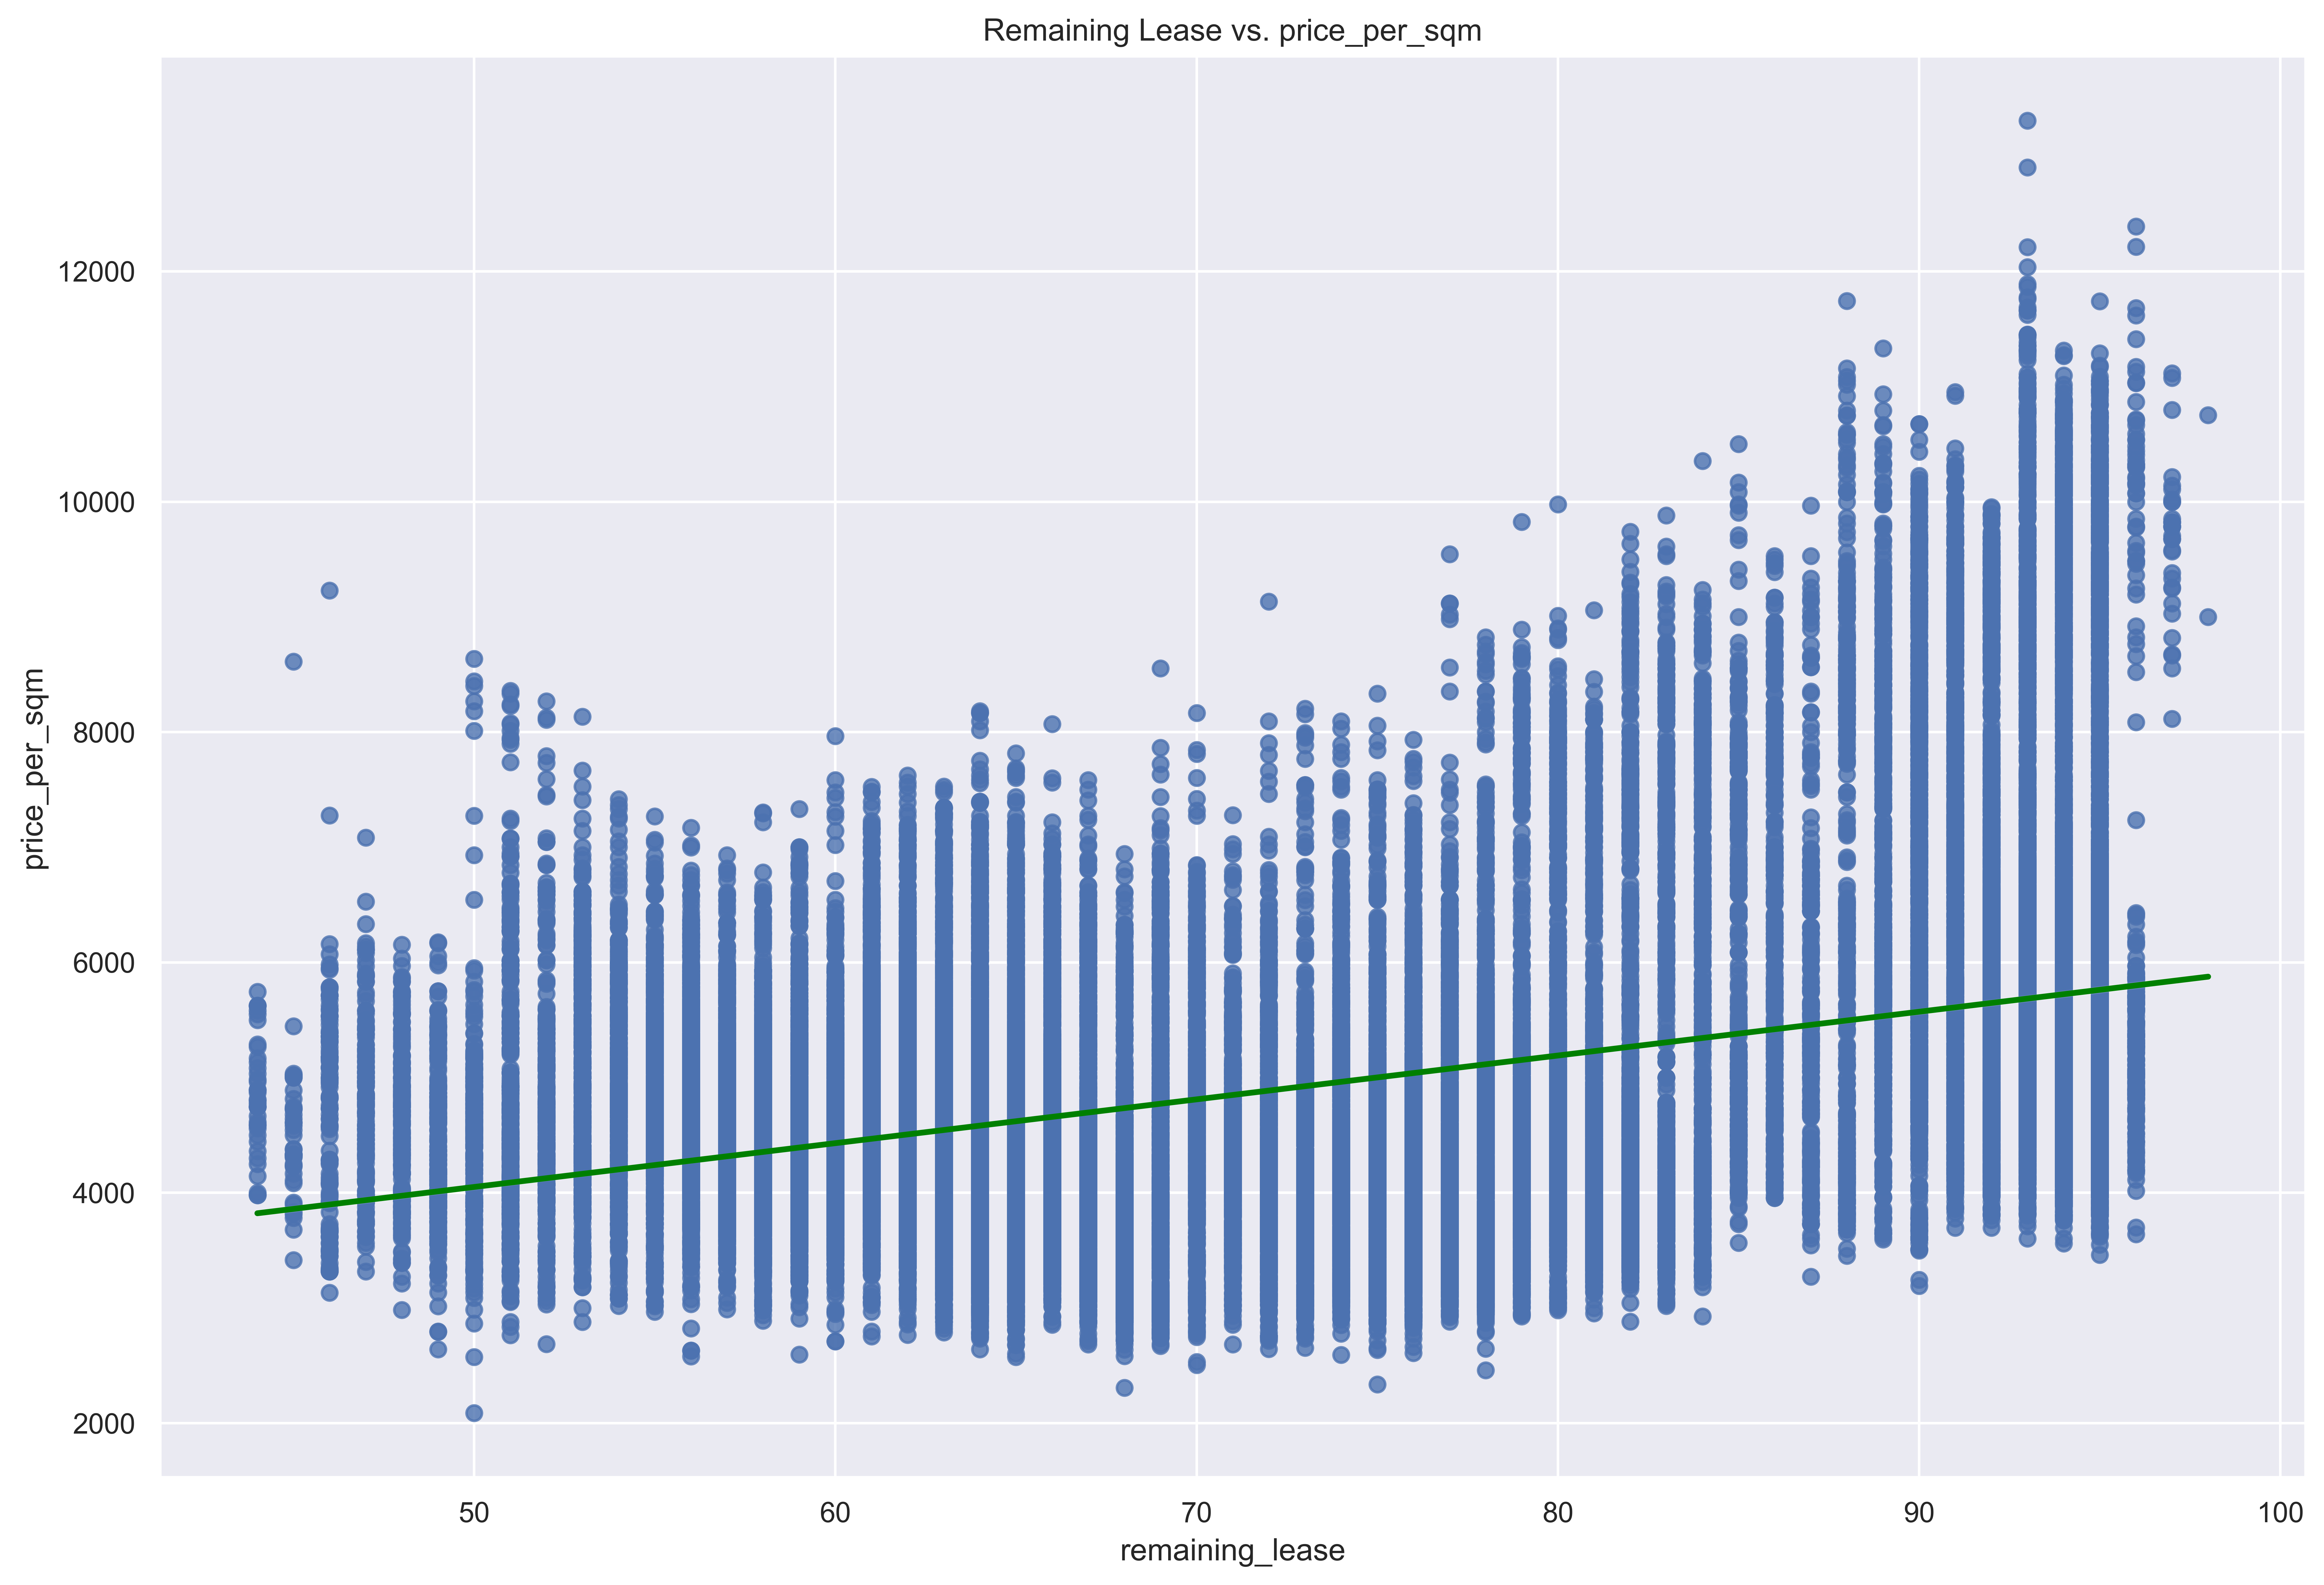

In [377]:
import seaborn as sns
sns.set_theme()
plt.figure(figsize=(15, 10), dpi = 600)
plt.title("Remaining Lease vs. price_per_sqm")
sns.regplot(data=imputed_dataset, x = 'remaining_lease', y = 'price_per_sqm', line_kws={"color": "green"})
plt.show()

From the regression line above, we can see there is a positive correlation between the remaining lease and the price per_sqm ie. as there is more remaining lease period, the price per sqm also increases

We also want to see the variation of resale price across different towns.

Write a script that shows the boxplot of `price_per_sqm` against varius `town`s. All towns should be listed in alphabetical order on the x-axis.

<div align="right"> (1 point) </div>

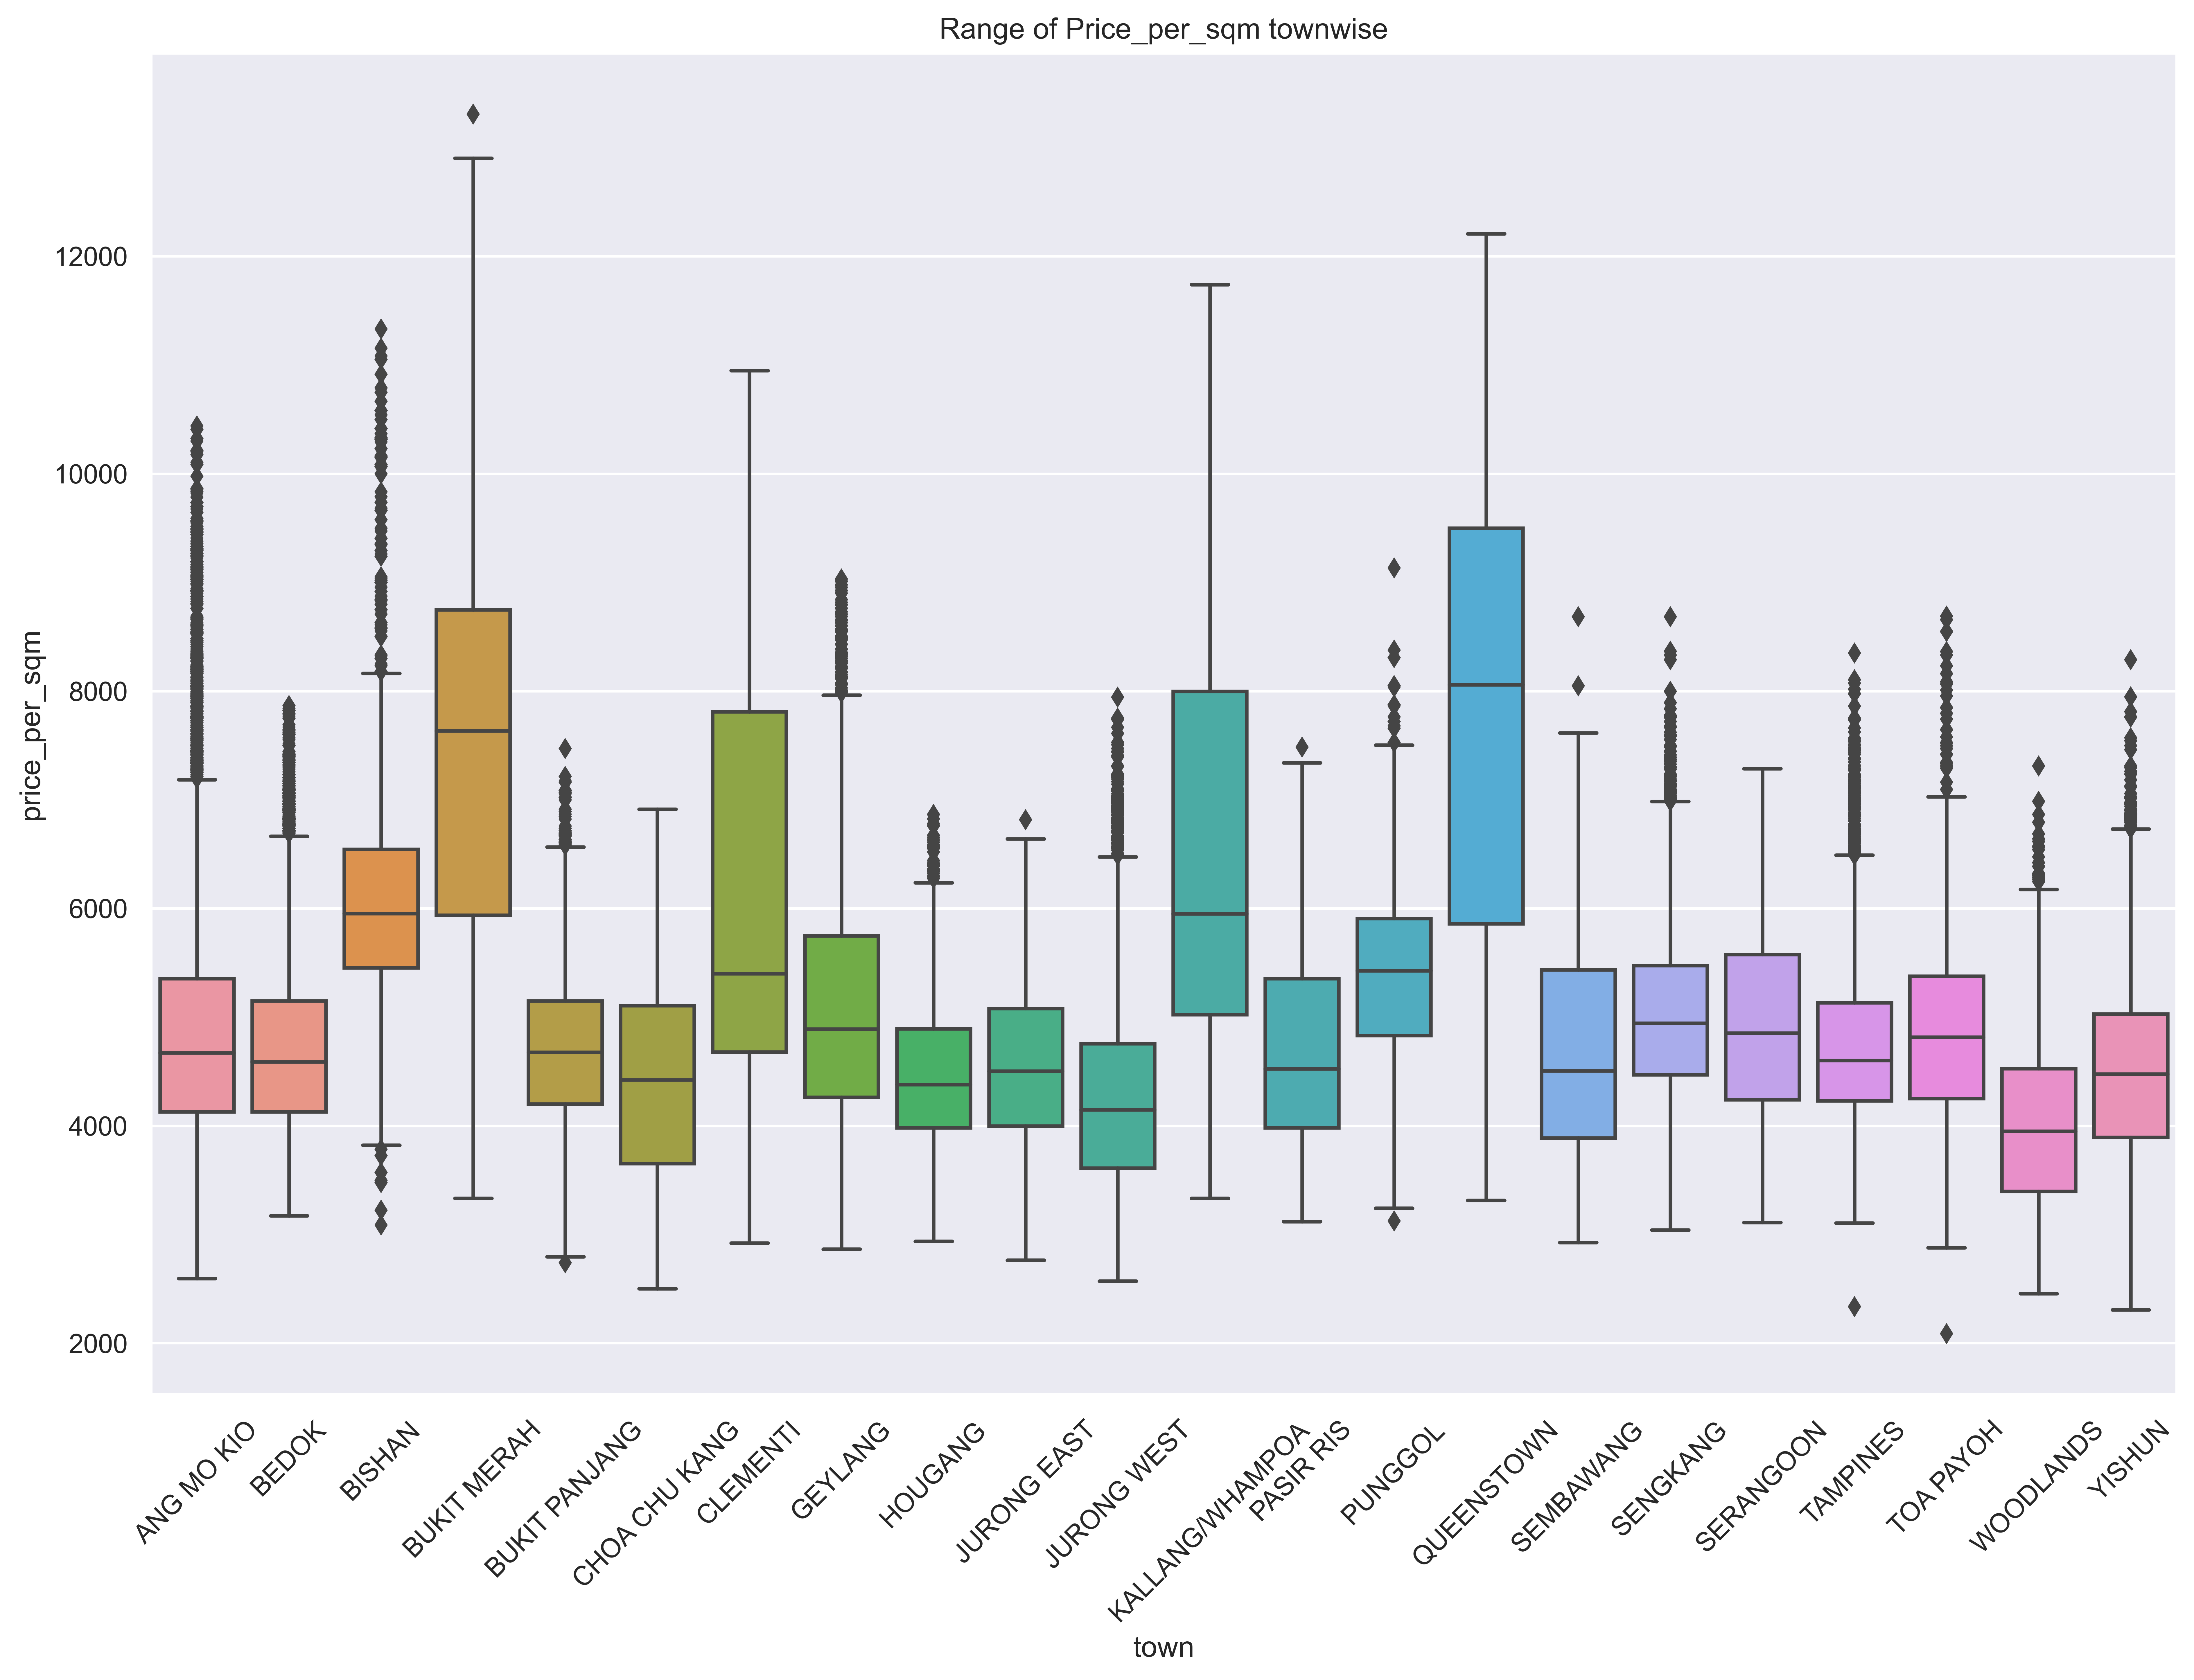

In [378]:
plt.figure(figsize=(15, 10), dpi = 600)
sns.boxplot(data=imputed_dataset, x='town', y='price_per_sqm')
plt.title("Range of Price_per_sqm townwise")
plt.xticks(rotation=45)
plt.show()

We want to observe the number of different `flat_type` that are sold over the last four years.

Write a script that would generate a plot that looks as follows.

<div align="right"> (2 points) </div>

<img src="https://www.comp.nus.edu.sg/~ashishd/IT5006/Assignments/Assignment_1/flat_type.png" alt="flat_type" width="500"/>

/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_85630/2068507149.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_dataset_year['flat_type'] = pd.Categorical(imputed_dataset_year['flat_type'], ['2 ROOM','3 ROOM','4 ROOM','5 ROOM'])


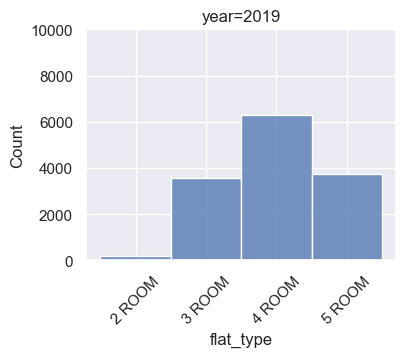

/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_85630/2068507149.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_dataset_year['flat_type'] = pd.Categorical(imputed_dataset_year['flat_type'], ['2 ROOM','3 ROOM','4 ROOM','5 ROOM'])


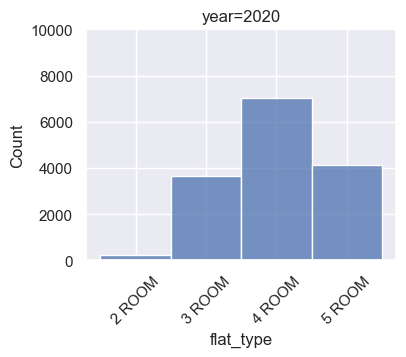

/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_85630/2068507149.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_dataset_year['flat_type'] = pd.Categorical(imputed_dataset_year['flat_type'], ['2 ROOM','3 ROOM','4 ROOM','5 ROOM'])


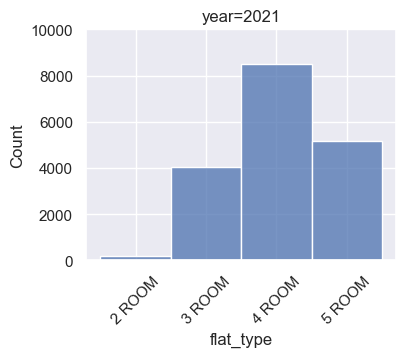

/var/folders/l_/xlcq7dfs5hb1cq7xjkkmbzr40000gn/T/ipykernel_85630/2068507149.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imputed_dataset_year['flat_type'] = pd.Categorical(imputed_dataset_year['flat_type'], ['2 ROOM','3 ROOM','4 ROOM','5 ROOM'])


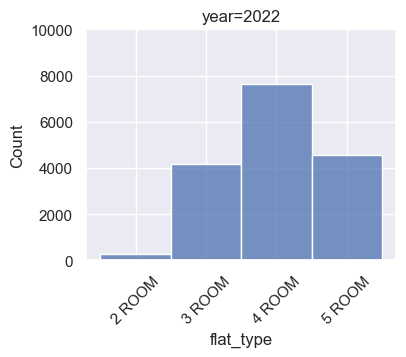

In [379]:
year_list = imputed_dataset['year'].unique()
for year in (2019,2020,2021,2022):
    imputed_dataset_year = imputed_dataset[imputed_dataset['year']==year]
    plt.figure(figsize=(4,3), dpi = 100)
    title = "year=" + str(year)
    plt.title(title)
    plt.ylim(0,10000)
    custom_bins = ['2 ROOM','3 ROOM','4 ROOM','5 ROOM']
    imputed_dataset_year['flat_type'] = pd.Categorical(imputed_dataset_year['flat_type'], ['2 ROOM','3 ROOM','4 ROOM','5 ROOM'])
    sns.histplot(data=imputed_dataset_year, x='flat_type', hue_order=custom_bins)
    plt.xticks(rotation=45)
    plt.show()

We want to observe the correlation between the resale price and the distance from the nearest MRT station.

Write a script that would generate a plot that looks as follows.

<div align="right"> (2 points) </div>

<img src="https://www.comp.nus.edu.sg/~ashishd/IT5006/Assignments/Assignment_1/price_mrt.png" alt="flat_type" width="800"/>

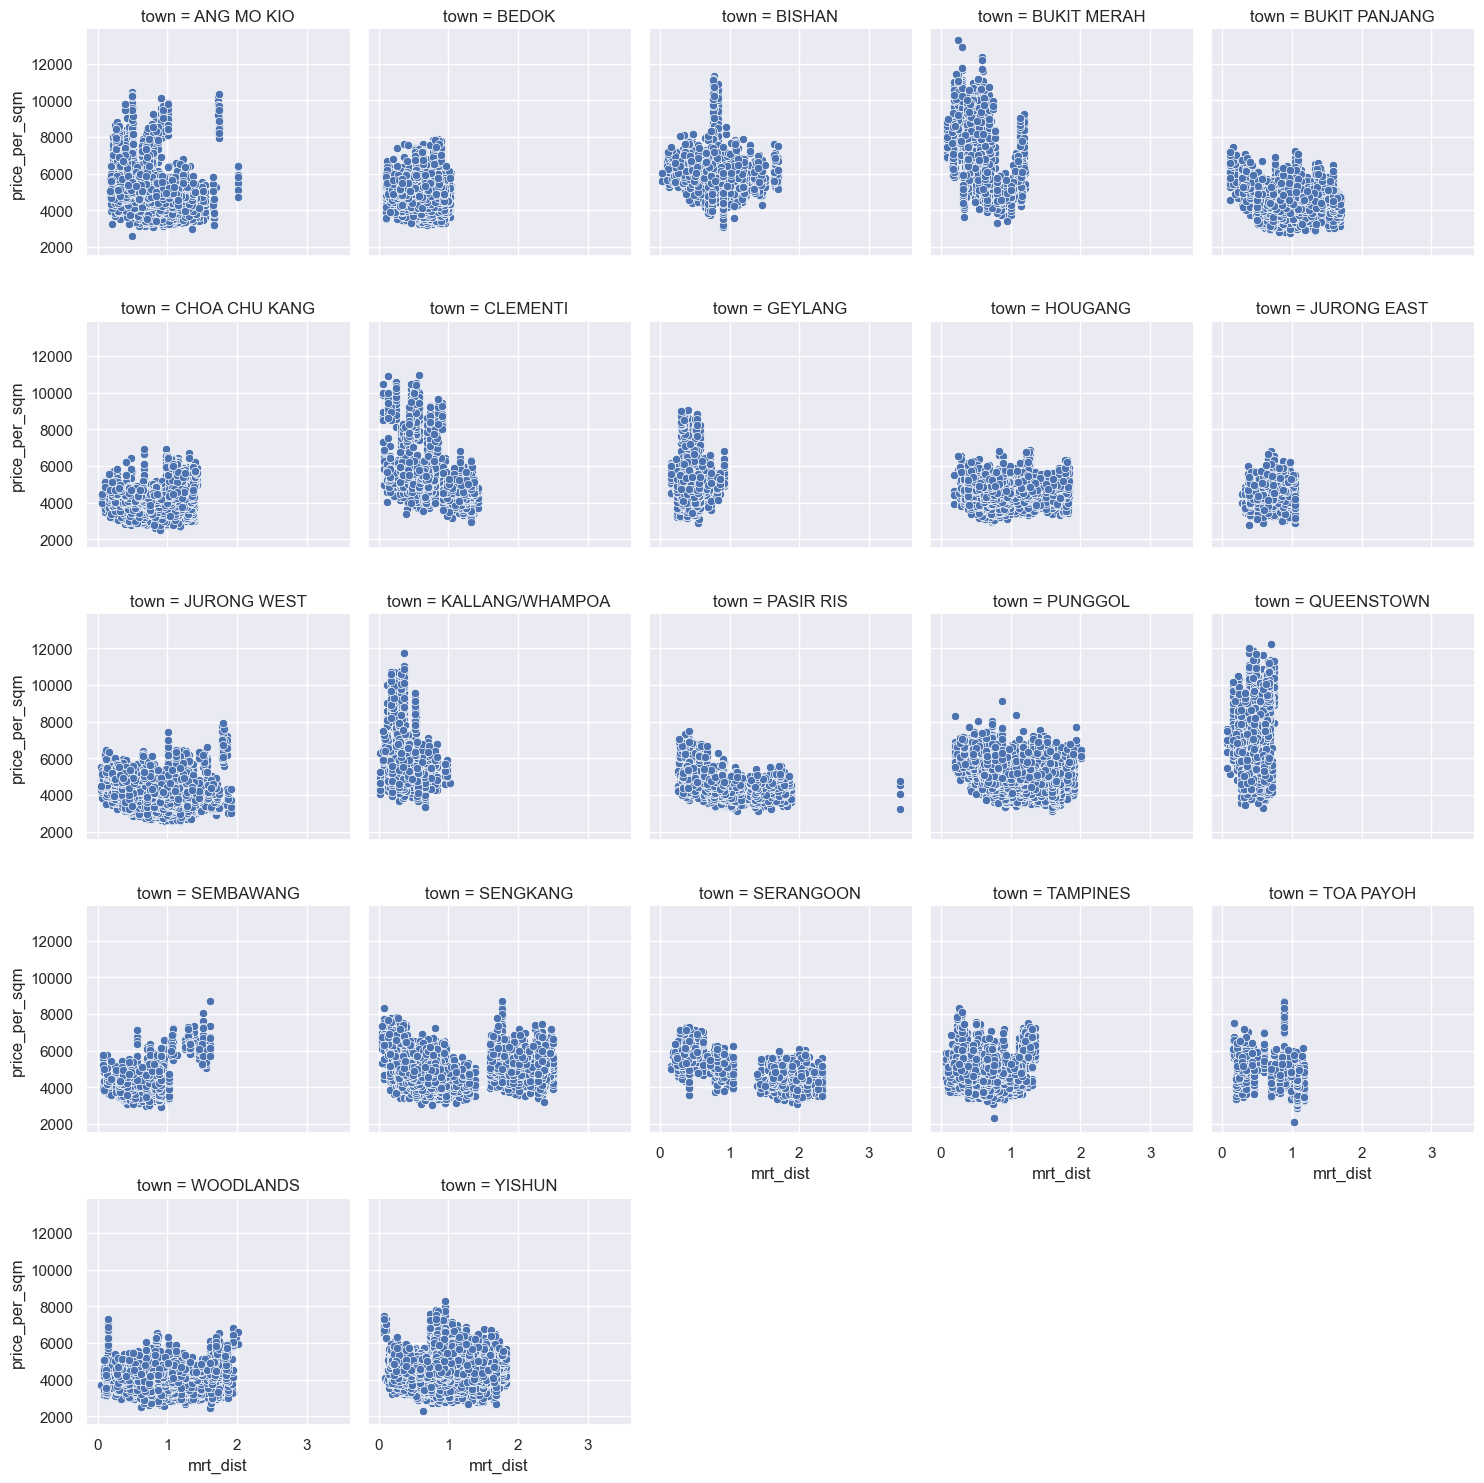

In [380]:
g = sns.FacetGrid(imputed_dataset, col='town', col_wrap=5)
g.map_dataframe(sns.scatterplot, x='mrt_dist', y='price_per_sqm')

## Question 5: Analysis

Which town shows the highest variability in the `price_per_sqm` in the last four years?

<div align="right"> (1 point) </div>

In [381]:
#highest variability in the price_per_sqm in the last four years?
import statistics as stat
#Range,SD and IQR
highest_range = 0
highest_SD = 0
highest_iqr = 0

for town in town_list:
    town_price_per_sqm = imputed_dataset[imputed_dataset['town']==town]['price_per_sqm']
    town_range = max(town_price_per_sqm) - min(town_price_per_sqm)
    if(town_range>highest_range):
        highest_range = town_range
        highest_range_town = town
    
    town_std_dev = stat.stdev(town_price_per_sqm)
    if(town_std_dev>highest_SD):
        highest_SD = town_std_dev
        highest_SD_town = town
    
    town_iqr = np.percentile(town_price_per_sqm, 75) - np.percentile(town_price_per_sqm, 25)
    if(town_iqr>highest_iqr):
        highest_iqr = town_iqr
        highest_iqr_town = town
        
print("Town with the highest range: ",highest_range_town,"Highest range: ", highest_range)
print("Town with the highest SD: ",highest_SD_town," Highest SD: ", highest_SD)
print("Town with the highest IQR: ",highest_iqr_town," Highest IQR: ", highest_iqr)

Town with the highest range:  BUKIT MERAH Highest range:  9977.011494252873
Town with the highest SD:  QUEENSTOWN  Highest SD:  2044.7791015101916
Town with the highest IQR:  QUEENSTOWN  Highest IQR:  3636.8027332144966


Answer:

Queenstown shows the highest variability in the price_per_sqm in the last four years.

As calculated above, range, standard deviation and interquartile range (IQR) can be considered as measures of variability. Standard Deviation (or Variance) is generally preferred as the best measure of variability since it takes the whole data into consideration. Hence, Queenstown shows the highest variability in the price_per_sqm in the last four years.


Which observation do you make looking at the resale records as per the `flat_type` over the years? What is a probable reason for the pattern that you observe?

<div align="right">(2 points)</div>

0.014255593668376499


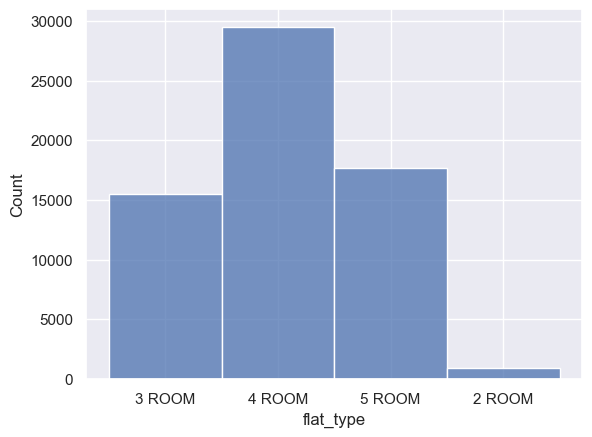

In [382]:
sns.histplot(data=imputed_dataset, x='flat_type')
print(len(imputed_dataset[imputed_dataset['flat_type']=='2 ROOM'])/len(imputed_dataset))

Observation 1: 4 ROOM flats rank the highest among the resold flat types not just over the last four years but also in each of the four years (followed by 5ROOM, 3ROOM and 2ROOM in that order. Reason: Among the different flat types, 4 ROOM is the most popular flat type in Singapore comprising about 40% of the total HDB flat types. Hence, it is only natural for the 4 ROOM flat type to be transacted the most.

Observation 2: Resale of 2ROOM flat types is significantly lesser than the other flat types. Reasons: One reason is 1 or 2 ROOM flats account for only 8.6% of the total HDB flat types. Even then, we see that 2 ROOM flat types are transacted proportinately lesser than other types (only 1.42% of the total transactions were 2 ROOM types). The probable reason for this is, in Singapore, a huge proportion of home owners rent rooms in their houses in order to earn extra income through it. With 2 ROOM flats, this is probably not possible. Hence there is less interest in buying 2 ROOM flats than other flat types.

Another reason for the preference of more bedroom flats could be attributed to the COVID pandemic because of which  people were in Work from Home and might have preferred to buy and move into a house with more rooms

We can observe that for many towns (such as Clementi, Bukit Merah, Pasir Ris, etc.) the `price_per_sqm` has a -ve correlation to the `mrt_dist`. This fits our hypothesis.

But some towns tend to show counter-intuitive behaviour. Please provide possible reasons behind these observation. You may support your answers by further analysing the available data.

- We observe a strong positive correlation for Sembawang (which means the houses closer to MRT are cheaper than the ones that are farther!). What is a probable reason?

- We observe two distinct clusters in the plot of Sengkang and Serangoon. What is a probable reason?
<div align="right">(2 points)</div>

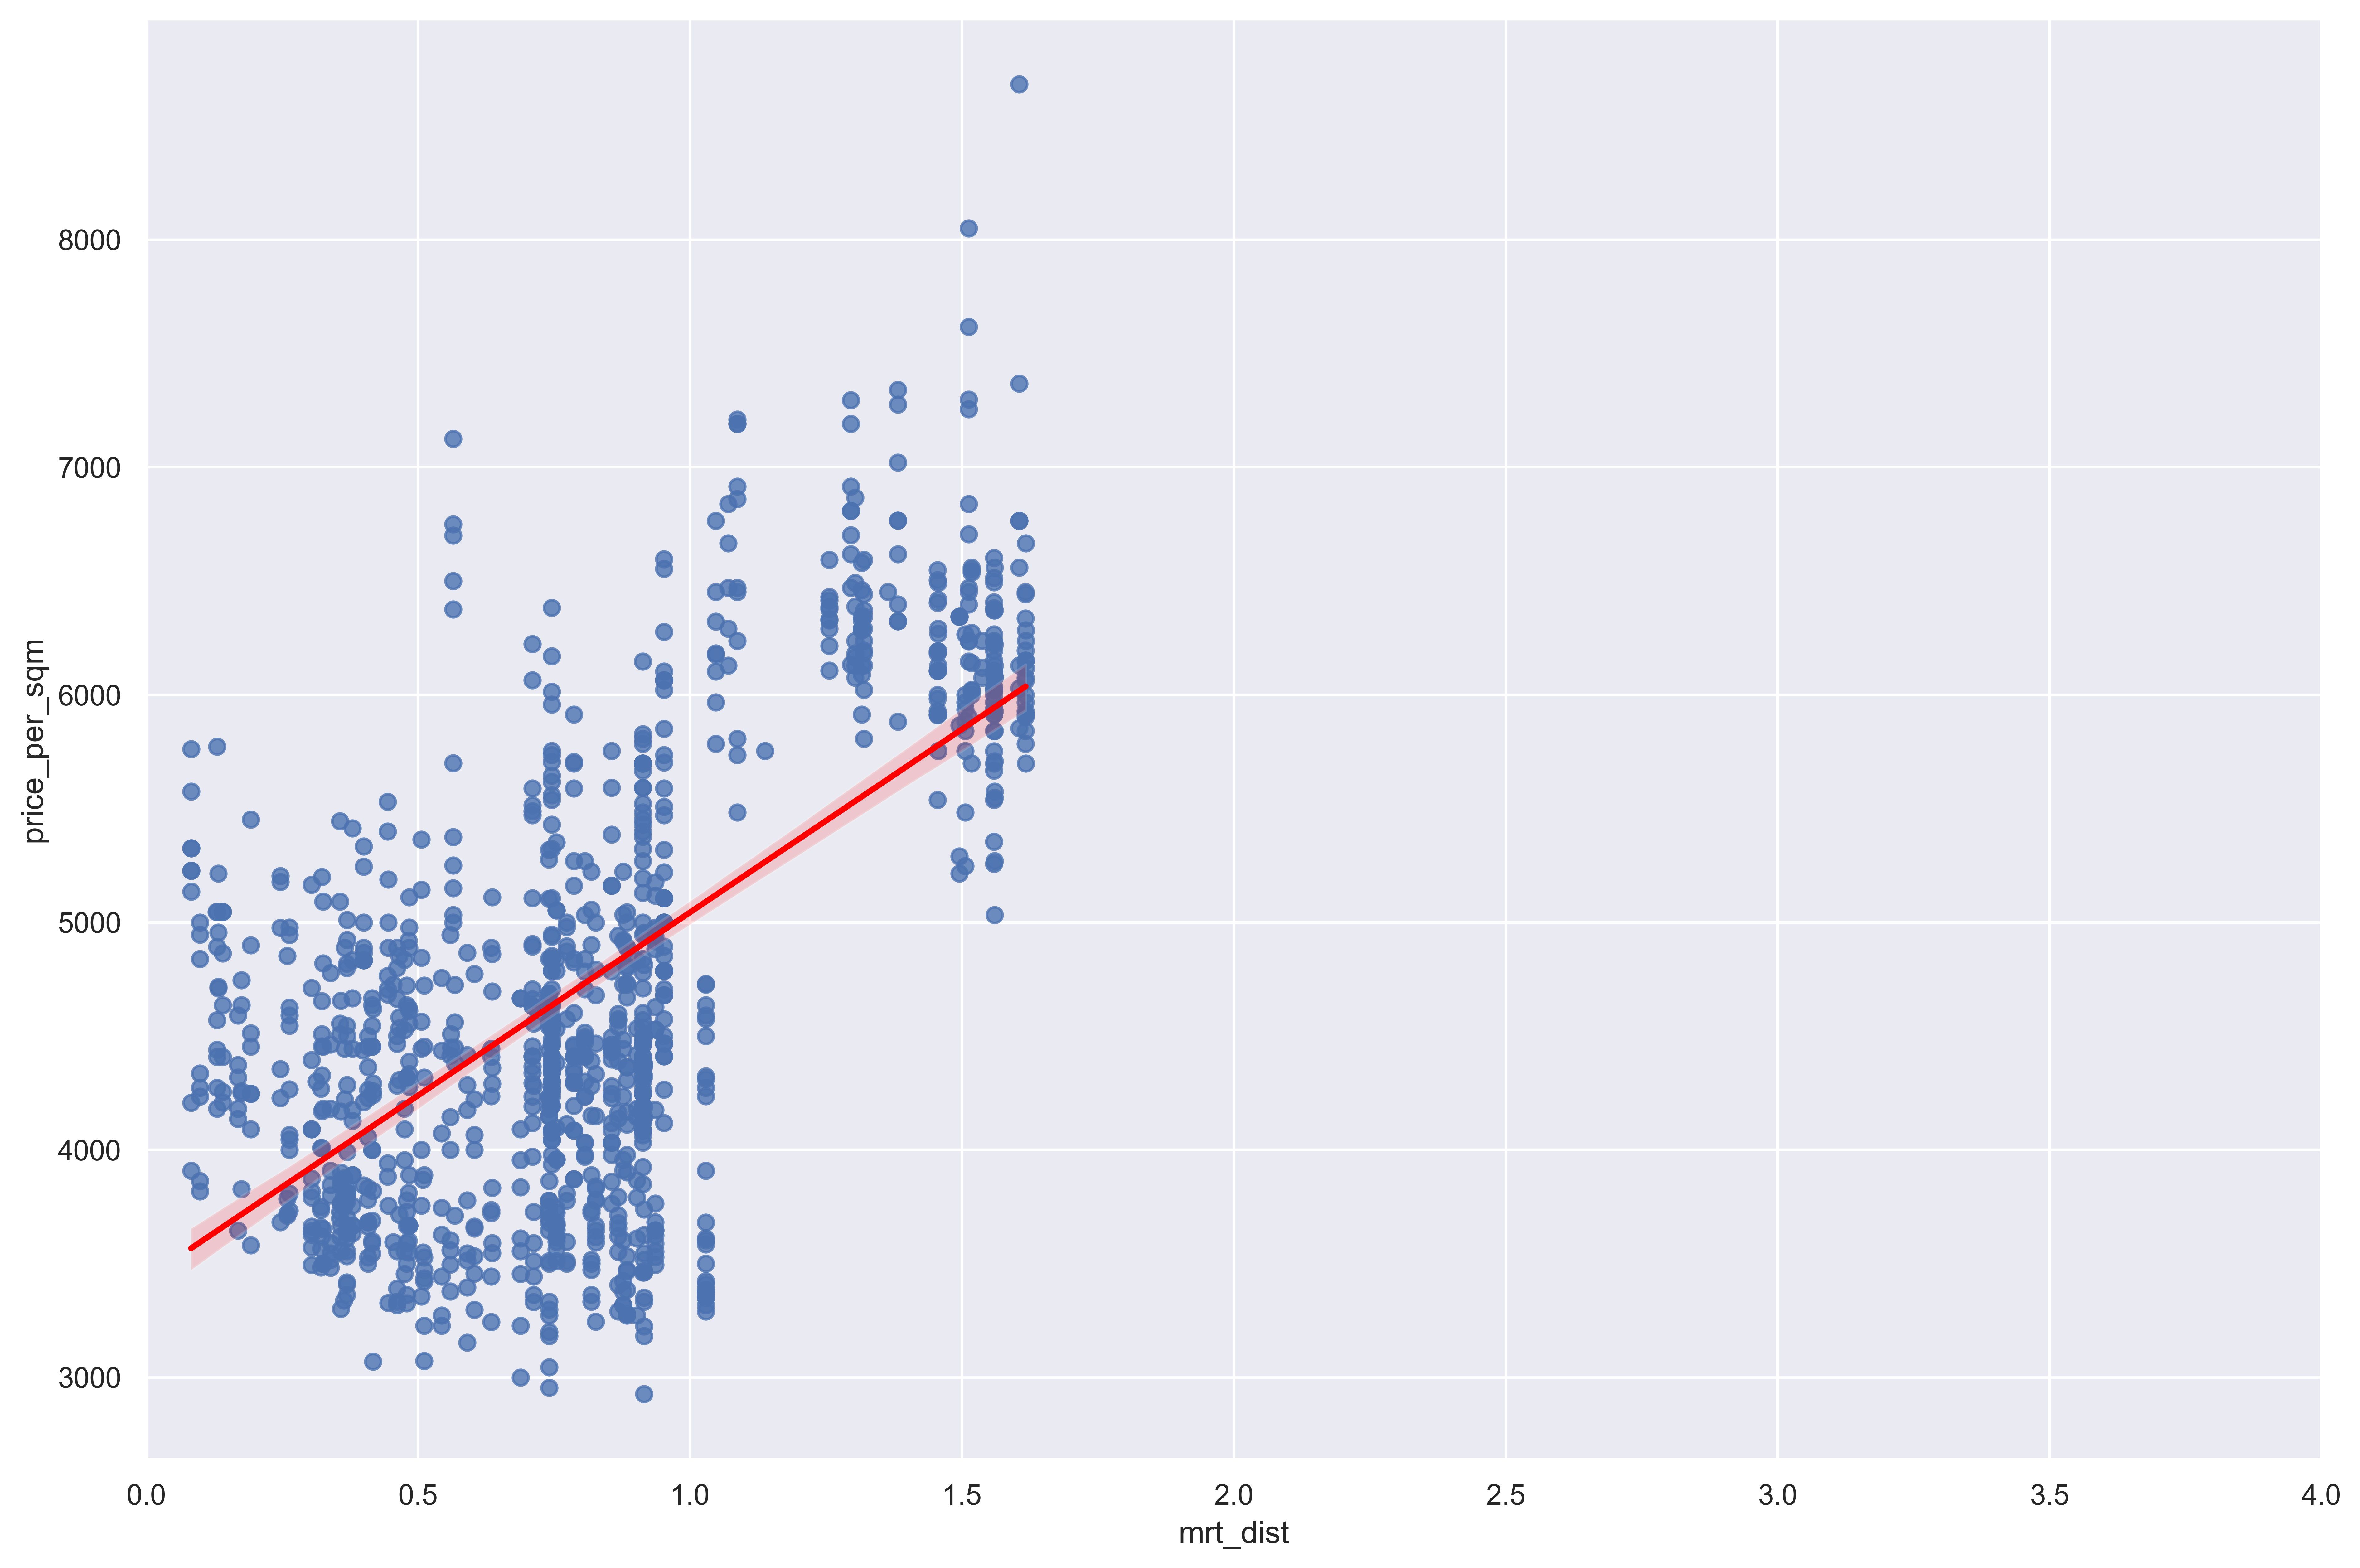

In [383]:
#We observe a strong positive correlation for Sembawang (which means the houses closer to MRT are cheaper than the ones that are farther!). Reason?
imputed_dataset_SEMBAWANG = imputed_dataset[imputed_dataset['town']=='SEMBAWANG']

plt.figure(figsize=(15,10), dpi = 600)
plt.xlim(0,4)
sns.regplot(data=imputed_dataset_SEMBAWANG, x = 'mrt_dist', y = 'price_per_sqm', line_kws={"color": "red"})
plt.show()

Probable reason for Observation 1:
Sembawang is a coastal town with many commercial and residential developments along the coastline. But the MRT stations (Red line) are located at the inland border of the Sembawang (away from the coastline). So, people prefer more to buy flats near the coastline (i.e. away from the MRT stations). That is the probable reason houses farther to the MRT are costlier than the ones near the MRT.



Probable reason for Observation 2: There appears to be two clusters in the Serangoon and Sengkang data. One probable reason is that there might not be any HDBs developed in that particular proximity interval as it is used for other purposes like development of parks, water reservoirs etc.